In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load CMS CutFlow

In [2]:
cmsData = pd.read_pickle('../AuxInfo/CMS-EXO-20-004-data/DMsimp_spin-1_Monojet_DF.pcl')
cmsData['filename'] = 'CMS'

### Add recast samples

In [3]:
files = {'recast1': '../scanResults_axial.pcl', 'recast2': '../scanResults_vector.pcl'}
allData = cmsData
for label,f in files.items():
    recastData = pd.read_pickle(f)
    recastData['filename'] = label
    allData = pd.concat((allData,recastData))
    
allData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
              ascending=[False,False,True,True,True])    

### Select model

In [4]:
modelFilter = {'Coupling' : 'Vector', 
 'Mode' : 'DM+QCDjets', 
 '$m_{med}$' : 2000.0,
 '$m_{DM}$' : 1.0,
 '$g_{DM}$' : 1.0,
 '$g_{q}$' : 0.25,
 'Data-takingperiod' : 2017}


textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in modelFilter.items()])
dfModel = allData.loc[(allData[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]

ratio = {}
for c in dfModel.columns:
    xList = dfModel[c].tolist()
    if all(isinstance(x,float) for x in xList):
        if xList[1]:
            ratio.update({c : [xList[0]/xList[1]]})
        else:
            ratio.update({c : [np.nan]})
dfRatio = pd.DataFrame.from_dict(ratio)
dfRatio.T

,0
$m_{med}$,1.000000
$m_{DM}$,1.000000
$g_{DM}$,1.000000
$g_{q}$,1.000000
Fullsample,1.000000
Triggeremulation,0.908646
$p_{T}^{miss}>250$GeV,1.034377
$p_{T}^{miss}$qualityfilters,NaN
Electronveto,1.030306
Muonveto,1.027332


In [5]:
modelFilter = {'Coupling' : 'Vector',
 'Mode' : 'DM+QCDjets', 
 '$m_{med}$' : 2000.0,
 '$m_{DM}$' : 1.0,
 '$g_{DM}$' : 1.0,
 '$g_{q}$' : 0.25,
 'Data-takingperiod' : 2017}


textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in modelFilter.items()])
dfModel = allData.loc[(allData[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]

relDiff = {}
for c in dfModel.columns:
    xList = dfModel[c].tolist()
    if all(isinstance(x,float) for x in xList):
        if xList[1]:
            relDiff.update({c : [np.abs(xList[1]-xList[0])/xList[1]]})
        else:
            relDiff.update({c : [np.nan]})
dfRel = pd.DataFrame.from_dict(relDiff)
dfRel.T

,0
$m_{med}$,0.000000
$m_{DM}$,0.000000
$g_{DM}$,0.000000
$g_{q}$,0.000000
Fullsample,0.000000
Triggeremulation,0.091354
$p_{T}^{miss}>250$GeV,0.034377
$p_{T}^{miss}$qualityfilters,NaN
Electronveto,0.030306
Muonveto,0.027332


In [8]:
dfModel.T

,324,433,281,433
Coupling,Vector,Vector,Axial,Axial
Mode,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets
$m_{med}$,2000.0,2000.0,2000.0,2000.0
$m_{DM}$,1.0,1.0,1.0,1.0
$g_{DM}$,1.0,1.0,1.0,1.0
$g_{q}$,0.25,0.25,0.25,0.25
Data-takingperiod,2017,2017,2017,2017
Fullsample,1.0,1.0,1.0,1.0
Triggeremulation,0.89835,0.988668,0.89878,0.984294
$p_{T}^{miss}>250$GeV,0.45225,0.43722,0.45603,0.424777


### Aux functions for plotting

In [6]:
def getBins(dfModel,rightBin = 2000.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and not 'Error' in c)}
    binsError = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'ErrorPlus' in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return bins,binsError,binCenter,binLeft
    
def getMETbins(dfSingle,bins,binsError):

    data = {c : dfSingle[c].iloc[0] for c in bins}
    dataError = {c : dfSingle[c].iloc[0] for c in binsError}

    return data,dataError

def getKfactors(data):

    # Define k-factors so the signal yield summed over all
    # MET bins equals CMS
    totCMS = sum(data['CMS'].values())
    kfactors = {label : totCMS/sum(data[label].values()) for label in data}    
    
    return kfactors


### Plot MET bins

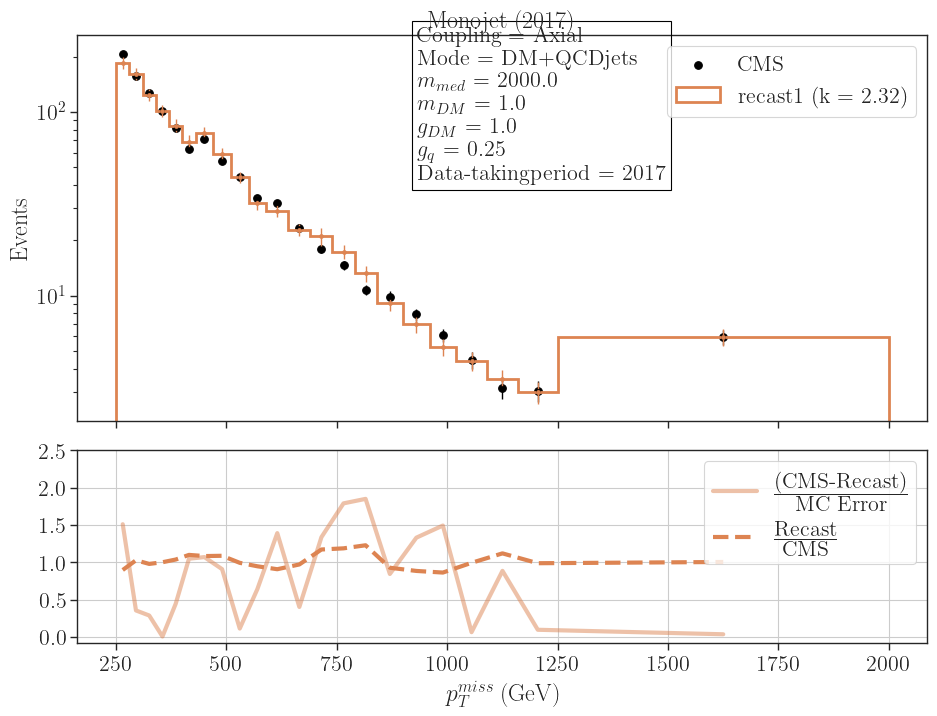

In [7]:
bins,binsError,binCenter,binLeft = getBins(dfModel)

for ds in dfModel['Data-takingperiod'].unique():
    dfDS = dfModel[dfModel['Data-takingperiod'] == ds]
    f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(10,8))
    plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)
    
    data = {}
    dataError = {}
    for label in dfDS['filename']:
        dfSingle = dfDS[dfDS['filename'] == label]
        d,dError = getMETbins(dfSingle,bins,binsError)
        data[label] = d
        dataError[label] = dError
    
    colors = {label : sns.color_palette('deep')[i] for i,label in enumerate(data.keys())}    
    colors['CMS'] = 'black'
    weightsCMS = np.array([data['CMS'][c] for c in bins])
    kfactors = getKfactors(data)
    for label in data:    
        kfactor = kfactors[label]
        weights = kfactor*np.array([data[label][c] for c in bins])
        error = kfactor*np.array([dataError[label][c] for c in binsError])    
        if label == 'CMS':        
            axarr[0].scatter(x=binCenter,y=weights,s=30,c=colors[label],label=label)
        else:
            axarr[0].hist(binCenter,bins=binLeft,
                           label=label+' (k = %1.2f)' %kfactor,linewidth=2,
                           weights=weights,histtype='step',
                          color=colors[label])



            relDiff = (weights-weightsCMS)/weightsCMS
            ratio = weights/weightsCMS
            relDiffErr = np.abs(weights-weightsCMS)/error
            #Plot ratio
            label1 = r'$\frac{\mbox{(CMS-Recast)}}{\mbox{MC Error}}$'
            label2 = r'$\frac{\mbox{Recast}}{\mbox{CMS}}$'
            axarr[1].plot(binCenter,relDiffErr,linewidth=3.0,color=colors[label],
                          label=label1,alpha=0.5)
            axarr[1].plot(binCenter,ratio,linewidth=3.0,color=colors[label],linestyle='--', 
                          label=label2)        

        axarr[0].errorbar(binCenter,weights,yerr = error, marker = '.', elinewidth=1.0,
                 drawstyle = 'steps-mid',linewidth=0.0,color=colors[label])


    axarr[1].set_yticks([0.,0.5,1.0,1.5,2.0,2.5])
    axarr[1].grid(True)
    axarr[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')
    axarr[0].set_yscale('log')
    axarr[0].set_ylabel('Events')
    axarr[0].legend()
    axarr[1].legend()
    
    axarr[0].text(0.4,2.4,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
    
    # axarr[0].set_ylim(1e-2,1e3)
    # axarr[0].set_xlim(250,1000)
    # axarr[1].set_ylim(0.5,1.5)
    axarr[0].set_title('Monojet (%s)' %ds)
    plt.show()
